# Comparison of T1-times estimated using LookLocker and Mixed sequence
In this notebook, we compare CSF $T_1$-times estimated from the mixed sequence with those of Look-Locker inversion-recovery relaxation analysis. The LL-estimates are  expected to be precise for lower ranges of $T_1$, whereas the mixed sequence is expected to be more precise for higher $T_1$-times.

The mixed-sequence also provide a $T_1$-map which is thresholded above by a value around 4000, making it inadequate for native $T_1$-times of CSF, but it might still be valid for in the presence of a constrast agent in the post-contrast sessions. 

The main figures for this purpose should be: Scatter plot comparing median $T_1$-values each region of the CSF-segmentation for both Look-Locker and Mixed. 
If we also bother with proccessing mixed-sequence T1-map, it should be a row with three scatter plots, one for each pair.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import simple_mri as sm
import skimage
import seaborn as sns
# import sklearn
from gmri2fem.utils import plot_orient, session_range

plt.rcParams.update({
    'font.size': 16,
    'axes.spines.top': False,
    'axes.spines.right': False
})

In [2]:
mri_proces = Path("../mri_processed_data/")
ll_paths = [
    f"../mri_processed_data/sub-01/registered/sub-01_ses-{idx:02d}_acq-looklocker_T1map_registered.nii.gz"
    for idx in range(1, 6)
]
ll_mris = [
    sm.load_mri(p, dtype=np.single) for p in ll_paths
]
ll = np.array([
    np.where(np.isin(mri.data, [0, np.nanmax(mri.data)]), np.nan, mri.data) for mri in ll_mris
])

mixed_paths = [
    f"../mri_processed_data/sub-01/registered/sub-01_ses-{idx:02d}_acq-mixed_T1map_registered.nii.gz"
    for idx in range(1, 6)
]
mixed_mris = [
    sm.load_mri(p, dtype=np.single) for p in mixed_paths
]
mixed = np.array([
    np.where(mri.data != 0, mri.data, np.nan) for mri in mixed_mris
])

scanner_paths = [
    f"../mri_processed_data/sub-01/registered/sub-01_ses-{idx:02d}_acq-mixed_T1map_scanner_registered.nii.gz"
    for idx in range(1, 6)
]
scanner_mris = [
    sm.load_mri(p, dtype=np.single) for p in scanner_paths
]
scanner = np.array([
    np.where((mri.data != 0), mri.data, np.nan) for mri in scanner_mris
])
#scanner = np.where(scanner < 4094.0, scanner, np.nan)
seg_mri = sm.load_mri(
    "../mri_processed_data/sub-01/segmentations/sub-01_seg-csf-aparc+aseg.nii.gz",
    dtype=np.single
)

In [3]:
seg = seg_mri.data
mask = seg != 0
labels = np.unique(seg).astype(int)

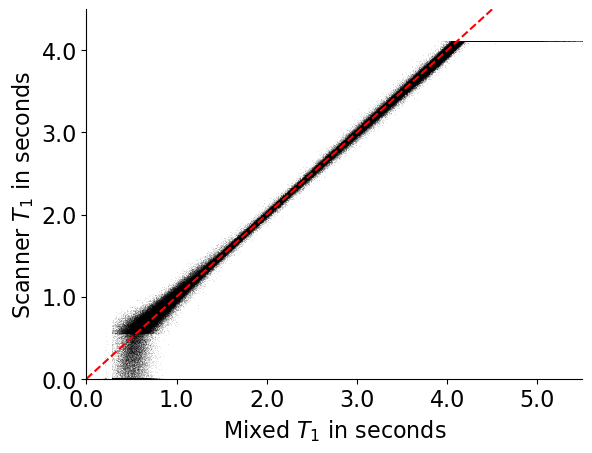

In [4]:
fig, axes = plt.subplots(sharey=True, sharex=True)
(scanner_i, mixed_i) = list(zip(scanner, mixed))[1]
ax = axes
ax.plot(mixed_i[mask], scanner_i[mask], ",", c="k", alpha=0.1)
ax.plot([0, 5000], [0, 5000], c="r", ls="--")
ticks_seconds = tuple(1.0*i for i in range(11))
plt.xticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.yticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
ax.set_xlim(0, 5500)
ax.set_ylim(0, 4500)
ax.set_xlabel("Mixed $T_1$ in seconds")
ax.set_ylabel("Scanner $T_1$ in seconds")
plt.savefig("../figures/mixed-scanner-scatter.png", bbox_inches="tight")
plt.show()

In [5]:
mixed.shape

(5, 368, 512, 512)

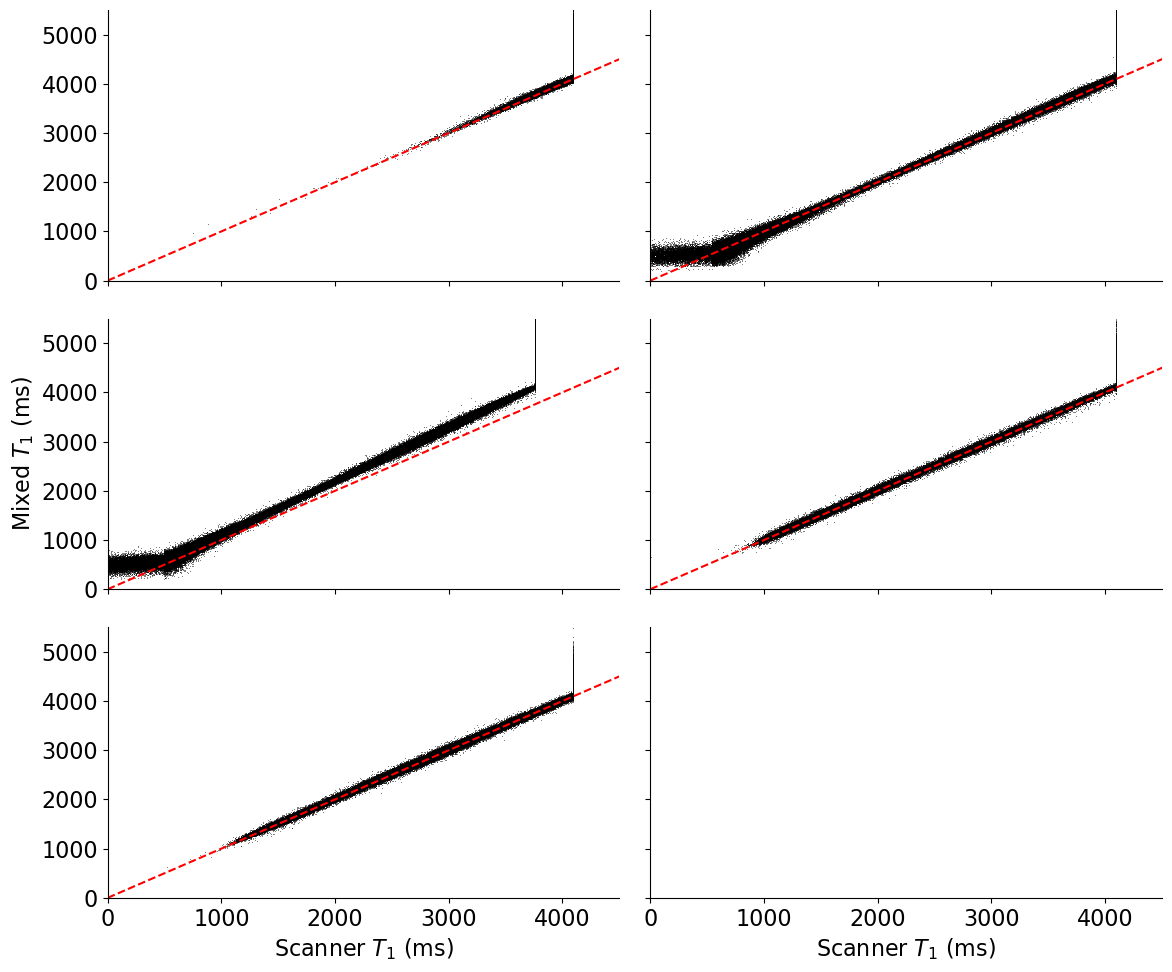

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharey=True, sharex=True)
axes = axes.ravel()
for idx, (scanner_i, mixed_i) in enumerate(zip(scanner, mixed)):
    ax = axes[idx]
    ax.plot(scanner_i[mask], mixed_i[mask], ",", c="k", alpha=0.50)
    ax.plot([0, 5000], [0, 5000], c="r", ls="--")
    ax.set_xlim(0, 4500)
    ax.set_ylim(0, 5500)

axes[2].set_ylabel("Mixed $T_1$ (ms)")
for ax in axes[-2:]:
    ax.set_xlabel("Scanner $T_1$ (ms)")
plt.tight_layout()
plt.show()

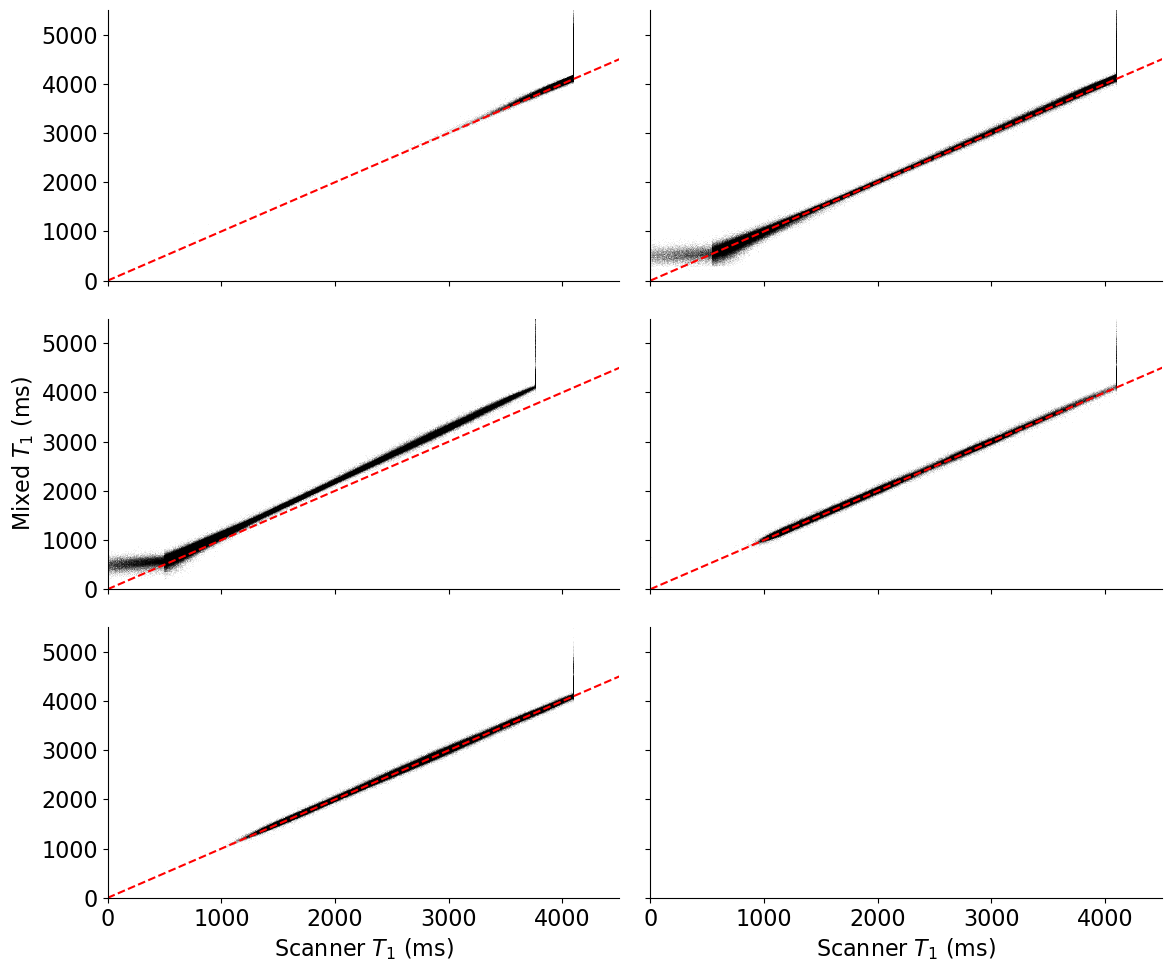

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharey=True, sharex=True)
axes = axes.ravel()
for idx, (scanner_i, mixed_i) in enumerate(zip(scanner, mixed)):
    ax = axes[idx]
    ax.plot(scanner_i[mask], mixed_i[mask], ",", c="k", alpha=0.05)
    ax.plot([0, 5000], [0, 5000], c="r", ls="--")
    ax.set_xlim(0, 4500)
    ax.set_ylim(0, 5500)

axes[2].set_ylabel("Mixed $T_1$ (ms)")
for ax in axes[-2:]:
    ax.set_xlabel("Scanner $T_1$ (ms)")
plt.tight_layout()
plt.show()

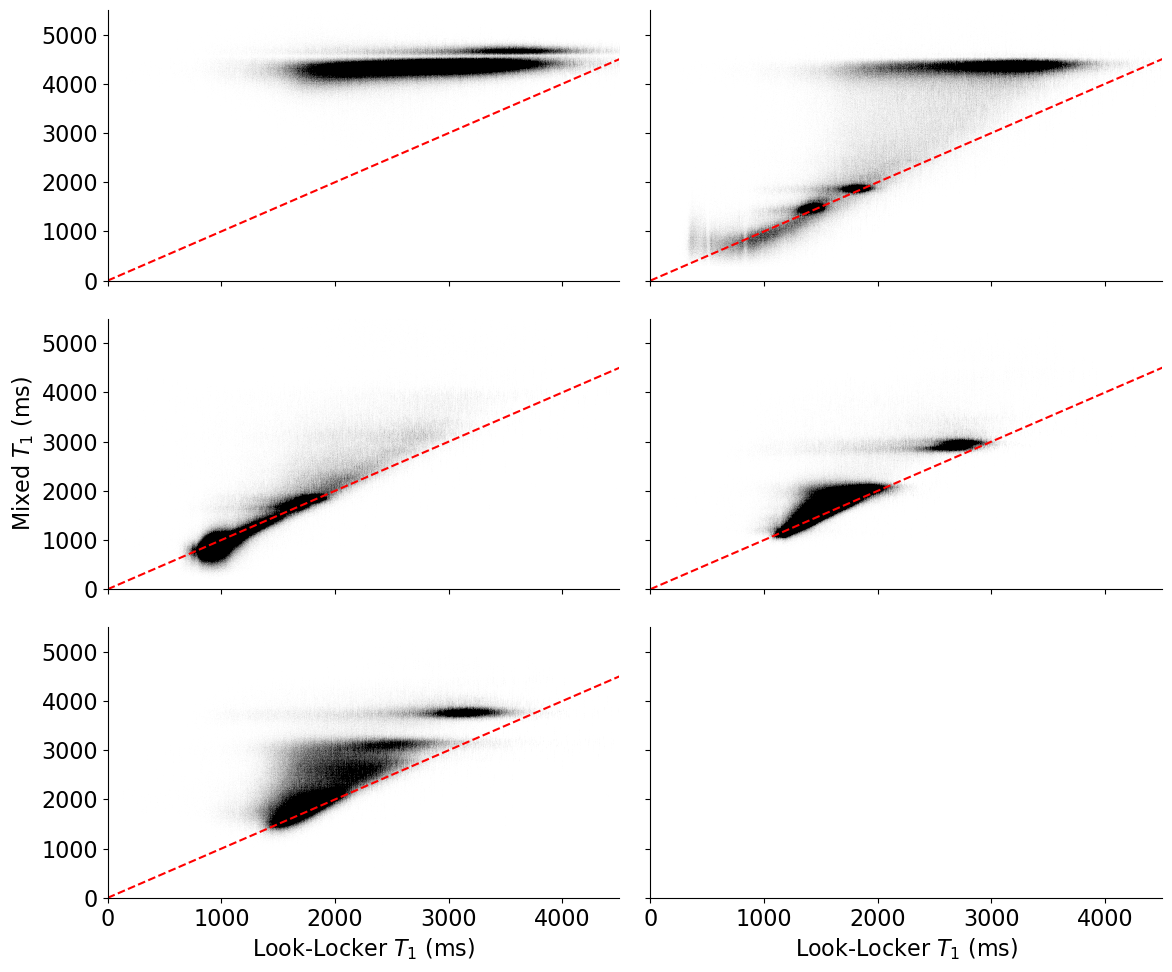

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharey=True, sharex=True)
axes = axes.ravel()
for idx, (scanner_i, mixed_i) in enumerate(zip(ll, mixed)):
    ax = axes[idx]
    ax.plot(scanner_i[mask], mixed_i[mask], ",", c="k", alpha=0.002)
    ax.plot([0, 5000], [0, 5000], c="r", ls="--")
    ax.set_xlim(0, 4500)
    ax.set_ylim(0, 5500)

axes[2].set_ylabel("Mixed $T_1$ (ms)")
for ax in axes[-2:]:
    ax.set_xlabel("Look-Locker $T_1$ (ms)")
plt.tight_layout()
plt.show()

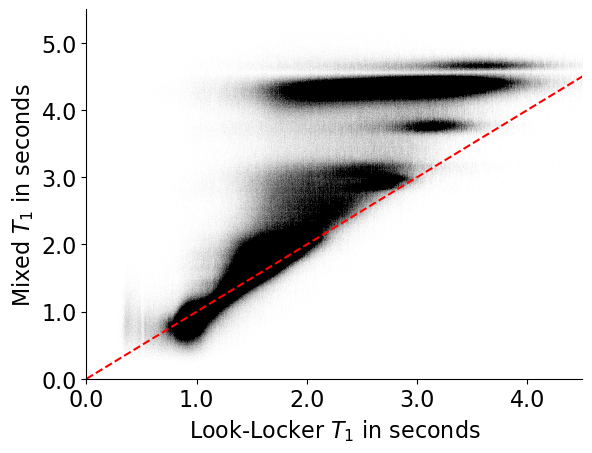

In [9]:
sessions = [f"ses-{idx:02d}" for idx in range(1, 6)]
ig, axes = plt.subplots()
ax = axes
for idx, (scanner_i, mixed_i) in enumerate(zip(ll, mixed)):
    ax.plot(scanner_i[mask], mixed_i[mask], ",", alpha=0.002, color="k", label=sessions[idx])
    
ticks_seconds = tuple(1.0*i for i in range(11))
plt.xticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.yticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
ax.plot([0, 5000], [0, 5000], c="r", ls="--")
ax.set_xlim(0, 4500)
ax.set_ylim(0, 5500)

ax.set_ylabel("Mixed $T_1$ in seconds")
ax.set_xlabel("Look-Locker $T_1$ in seconds")
# plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1), frameon=False)
plt.savefig("../figures/LL-mixed-T1-scatter-voxelwise.png", bbox_inches="tight")
plt.show()

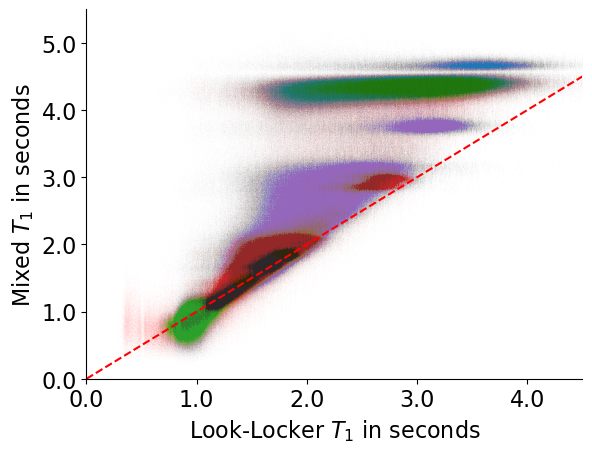

In [10]:
fig, axes = plt.subplots()
ax = axes
for idx, (scanner_i, mixed_i) in enumerate(zip(ll, mixed)):
    ax.plot(scanner_i[mask], mixed_i[mask], ",", alpha=0.002, label=sessions[idx])
    
ticks_seconds = tuple(1.0*i for i in range(11))
plt.xticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.yticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
ax.plot([0, 5000], [0, 5000], c="r", ls="--")
ax.set_xlim(0, 4500)
ax.set_ylim(0, 5500)

ax.set_ylabel("Mixed $T_1$ in seconds")
ax.set_xlabel("Look-Locker $T_1$ in seconds")
plt.savefig("../figures/LL-mixed-T1-scatter-voxelwise-colored.png", bbox_inches="tight")
plt.show()

In [11]:
records = []
for label in labels[1:]:
    segment_mask = (seg == label)
    segment_mask = skimage.morphology.binary_erosion(
        segment_mask,
        footprint=skimage.morphology.cube(3),
    )
    segment_size = segment_mask.sum()
    if segment_size < 100:
        continue
    for idx, ses in enumerate(session_range(5)):
        segment_ll_vals = ll[idx][segment_mask]
        segment_mixed_vals = mixed[idx][segment_mask]
        segment_scanner_vals = scanner[idx][segment_mask]

        if np.isfinite(segment_ll_vals).sum() == 0 or np.isfinite(segment_mixed_vals).sum() == 0:
            continue
        records.append({
            "label": label,
            "session": ses,
            "size": segment_size,
            "looklocker-median": np.nanmedian(segment_ll_vals),
            "mixed-median": np.nanmedian(segment_mixed_vals),
            "scanner-median": np.nanmedian(segment_scanner_vals),
            "looklocker-std": np.nanstd(segment_ll_vals),
            "mixed-std": np.nanstd(segment_mixed_vals),
            "scanner-std": np.nanstd(segment_scanner_vals),

        })


dframe = pd.DataFrame.from_records(records)
dframe

/tmp/ipykernel_31041/3349736931.py:6: FutureWarning: `cube` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  footprint=skimage.morphology.cube(3),


,label,session,size,looklocker-median,mixed-median,scanner-median,looklocker-std,mixed-std,scanner-std
0,2,ses-01,214,3043.114990,4323.5,4094.999512,387.791962,169.204788,44.008778
1,2,ses-02,214,854.532288,783.0,752.368164,100.850868,132.781555,330.324890
2,2,ses-03,214,988.407227,897.5,820.052917,63.650967,152.808517,138.919052
3,2,ses-04,214,1832.678223,2066.5,2064.008301,176.965088,81.167603,79.340790
4,2,ses-05,214,2456.786133,3072.0,3068.498535,287.562378,83.164986,84.832397
...,...,...,...,...,...,...,...,...,...
400,2035,ses-01,3863,3087.130859,4374.0,4094.999512,387.201477,69.136475,1.361344
401,2035,ses-02,3863,848.734863,844.0,798.390625,170.958664,181.413635,367.978271
402,2035,ses-03,3863,893.124634,866.0,788.824097,44.196457,129.513184,162.806351
403,2035,ses-04,3863,1637.367310,1691.0,1690.826172,85.313087,92.799835,92.980667


In [12]:
sessions = [f"ses-{idx:02d}" for idx in range(1, 6)]

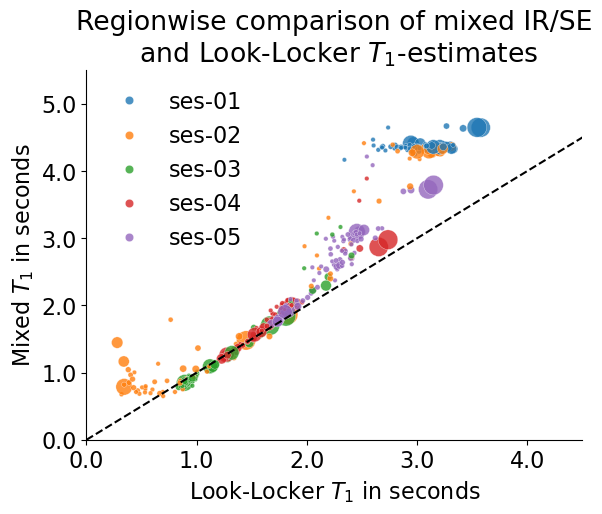

In [13]:
ticks_seconds = tuple(1.0*i for i in range(11))
fig, ax = plt.subplots()
g = sns.scatterplot(
    dframe,
    x="looklocker-median",
    y="mixed-median",
    hue="session",
    marker="o",
    size="size",
    sizes=(10, 200),  # Define min and max size
    size_norm=(0, dframe["size"].max()),  # Linear scaling,
    alpha=0.8,
    legend=True
)
plt.plot([0, 10000], [0, 10000], color="k", ls="--")
plt.ylabel("Mixed $T_1$ in seconds")
plt.xlabel("Look-Locker $T_1$ in seconds")
plt.xticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.yticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.xlim(0, 4500)
plt.ylim(0, 5500)
handles, labels = g.get_legend_handles_labels()
plt.legend(handles=handles[1:6], labels=labels[1:6], frameon=False)
plt.title("Regionwise comparison of mixed IR/SE\n and Look-Locker $T_1$-estimates")
plt.savefig("../figures/LL-mixed-T1-scatter-regionwise-colored.pdf", bbox_inches="tight")
plt.show()

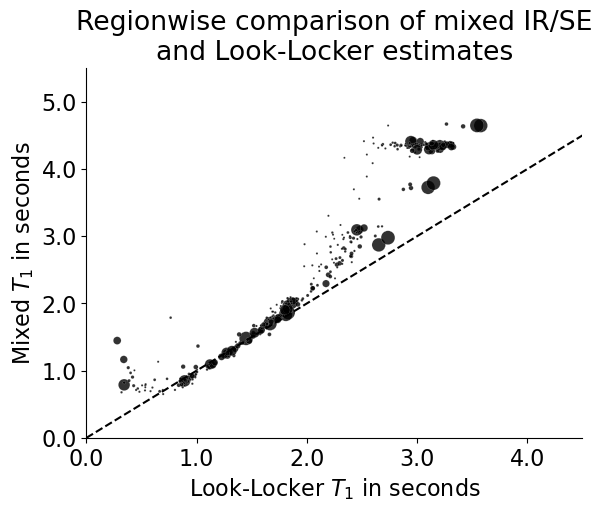

In [14]:
fig, ax = plt.subplots()
g = sns.scatterplot(
    dframe,
    x="looklocker-median",
    y="mixed-median",
    marker="o",
    size="size",
    sizes=(2, 100),
    size_norm=(0, dframe["size"].max()),
    alpha=0.8,
    legend=False,
    color="k"
)
plt.plot([0, 10000], [0, 10000], color="k", ls="--")
plt.ylabel("Mixed $T_1$ in seconds")
plt.xlabel("Look-Locker $T_1$ in seconds")
plt.xticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.yticks([1000 * xi for xi in ticks_seconds], ticks_seconds)
plt.xlim(0, 4500)
plt.ylim(0, 5500)
# handles, labels = g.get_legend_handles_labels()
# plt.legend(handles=handles[1:6], labels=labels[1:6], frameon=False)
plt.title("Regionwise comparison of mixed IR/SE\nand Look-Locker estimates")
plt.savefig("../figures/LL-mixed-T1-scatter-regionwise.pdf", bbox_inches="tight")
plt.show()

In [15]:
import matplotlib as mpl

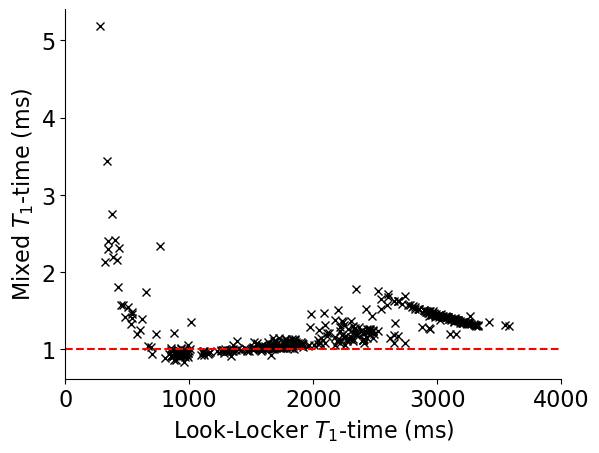

In [16]:
plt.plot(dframe["looklocker-median"], dframe["mixed-median"] / dframe["looklocker-median"], "x", c="k")
plt.plot([0, 5000], [1, 1], c="r", ls="--")
plt.xlim(0, 4000)
# plt.ylim(0, 5000)
plt.xlabel("Look-Locker $T_1$-time (ms)")
plt.ylabel("Mixed $T_1$-time (ms)")
# plt.savefig("../figures/LL-mixed-T1-scatter.pdf", bbox_inches="tight")
plt.show()

## Scanner T1-map

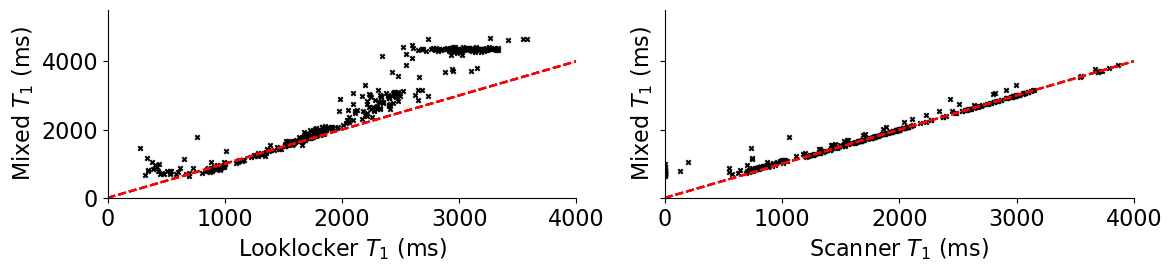

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
for idx, pair in enumerate([("looklocker", "mixed"), ("scanner", "mixed")]):
    ax = axes[idx]
    for ses_idx, ses in enumerate(np.unique(dframe["session"])):
        x = dframe.loc[dframe["session"] == ses][f"{pair[0]}-median"]
        y = dframe.loc[dframe["session"] == ses][f"{pair[1]}-median"]
        ax.scatter(x, y, marker="x", s=10, c="k")
        ax.plot([0, 6000], [0, 6000], c="r", ls="--")
    ax.set_xlim(0, 4000)
    ax.set_ylim(0, 5500)
    ax.set_xlabel(f"{pair[0].title()} $T_1$ (ms)")
    ax.set_ylabel(f"{pair[1].title()} $T_1$ (ms)")
plt.savefig("../figures/LL-mixed-scanner-T1-scatter.pdf", bbox_inches="tight")
plt.savefig("../figures/LL-mixed-scanner-T1-scatter.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

### Relative Plots

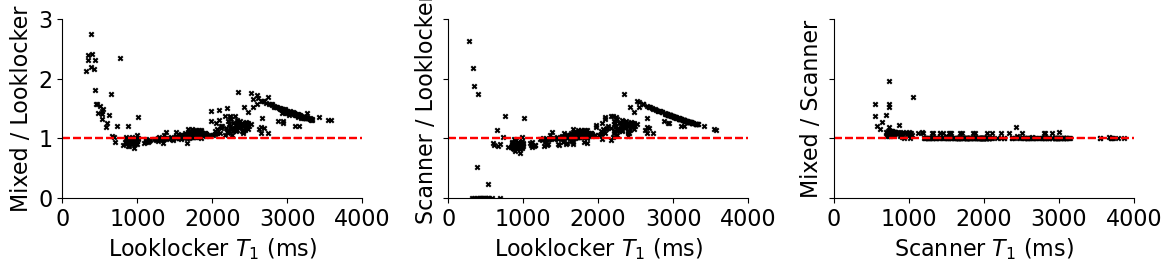

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for idx, pair in enumerate([("looklocker", "mixed"), ("looklocker", "scanner"), ("scanner", "mixed")]):
    ax = axes[idx]
    for ses_idx, ses in enumerate(np.unique(dframe["session"])):
        x = dframe.loc[dframe["session"] == ses][f"{pair[0]}-median"]
        y = dframe.loc[dframe["session"] == ses][f"{pair[1]}-median"]
        ax.scatter(x, y / x, marker="x", s=10, c="k")
        ax.plot([0, 6000], [1, 1], c="r", ls="--")
    ax.set_xlim(0, 4000)
    ax.set_xlabel(f"{pair[0].title()} $T_1$ (ms)")
    ax.set_ylabel(f"{pair[1].title()} / {pair[0].title()}")
    ax.set_ylim(0, 3)
plt.savefig("../figures/LL-mixed-scanner-T1-scatter-relative.pdf", bbox_inches="tight")
plt.savefig("../figures/LL-mixed-scanner-T1-scatter-relative.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

## Pre-registered comparison of mixed and T1-weighted

In [19]:
mixed_paths = [
    f"../mri_dataset/derivatives/sub-01/ses-{idx:02d}/sub-01_ses-{idx:02d}_acq-mixed_T1map.nii.gz" for idx in range(1, 6)
]
mixed_mris = [sm.load_mri(p, dtype=np.single) for p in mixed_paths]
mixed = np.array([np.where(mri.data != 0, mri.data, np.nan) for mri in mixed_mris])

scanner_paths = [
    f"../mri_dataset/sub-01/ses-{idx:02d}/mixed/sub-01_ses-{idx:02d}_acq-mixed_T1map_scanner.nii.gz" for idx in range(1, 6)
]
scanner_mris = [sm.load_mri(p, dtype=np.single) for p in scanner_paths]
scanner = np.array([np.where(mri.data != 0, mri.data, np.nan) for mri in scanner_mris])

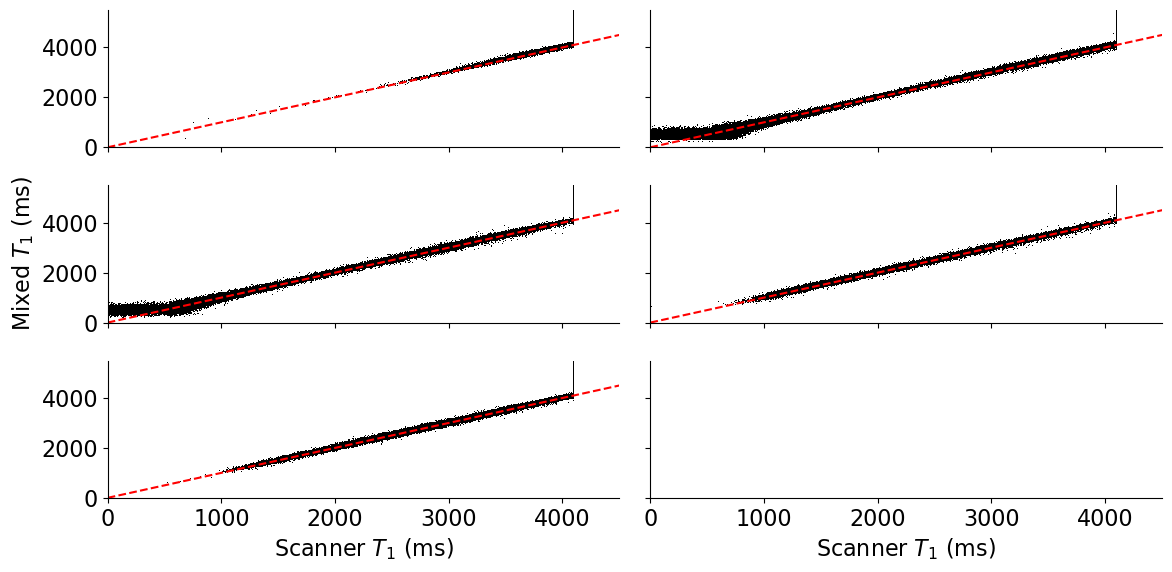

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12,6), sharey=True, sharex=True)
axes = axes.ravel()
for idx, (scanner_i, mixed_i) in enumerate(zip(scanner, mixed)):
    ax = axes[idx]
    ax.plot(scanner_i.ravel() * (4095 / np.nanmax(scanner_i)), mixed_i.ravel(), ",", c="k")
    ax.plot([0, 5000], [0, 5000], c="r", ls="--")
    ax.set_xlim(0, 4500)
    ax.set_ylim(0, 5500)

axes[2].set_ylabel("Mixed $T_1$ (ms)")
for ax in axes[-2:]:
    ax.set_xlabel("Scanner $T_1$ (ms)")
plt.tight_layout()
plt.show()